## Processing Pipeline

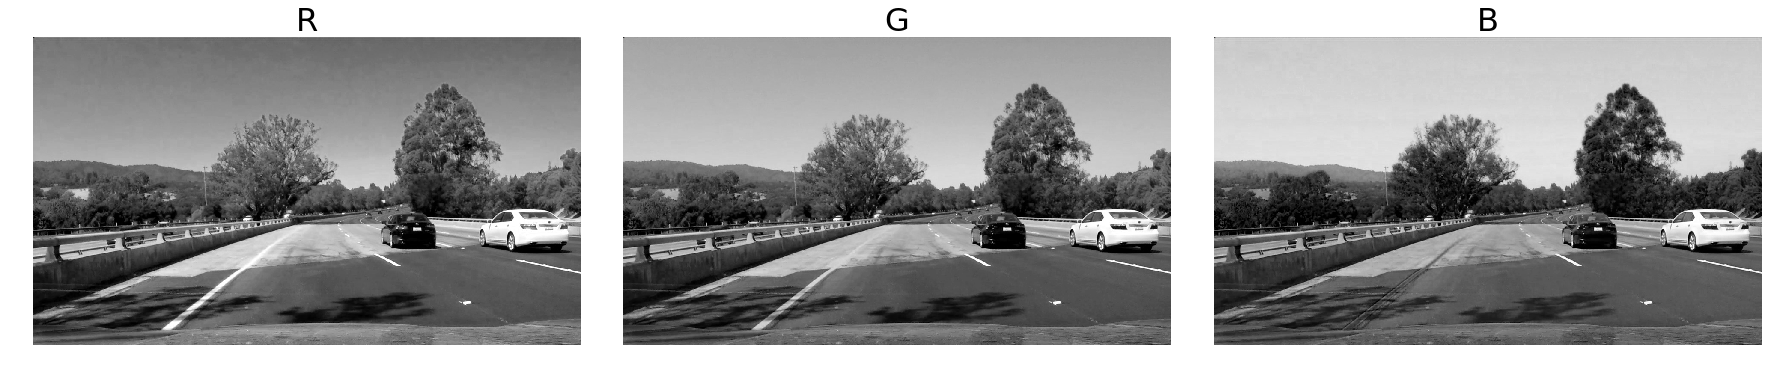

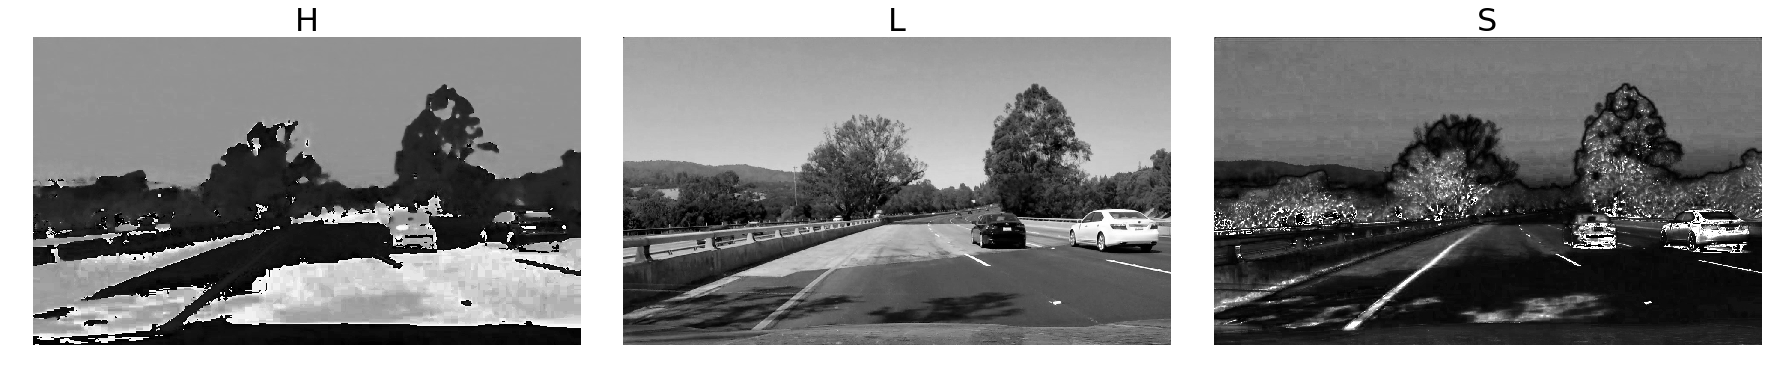

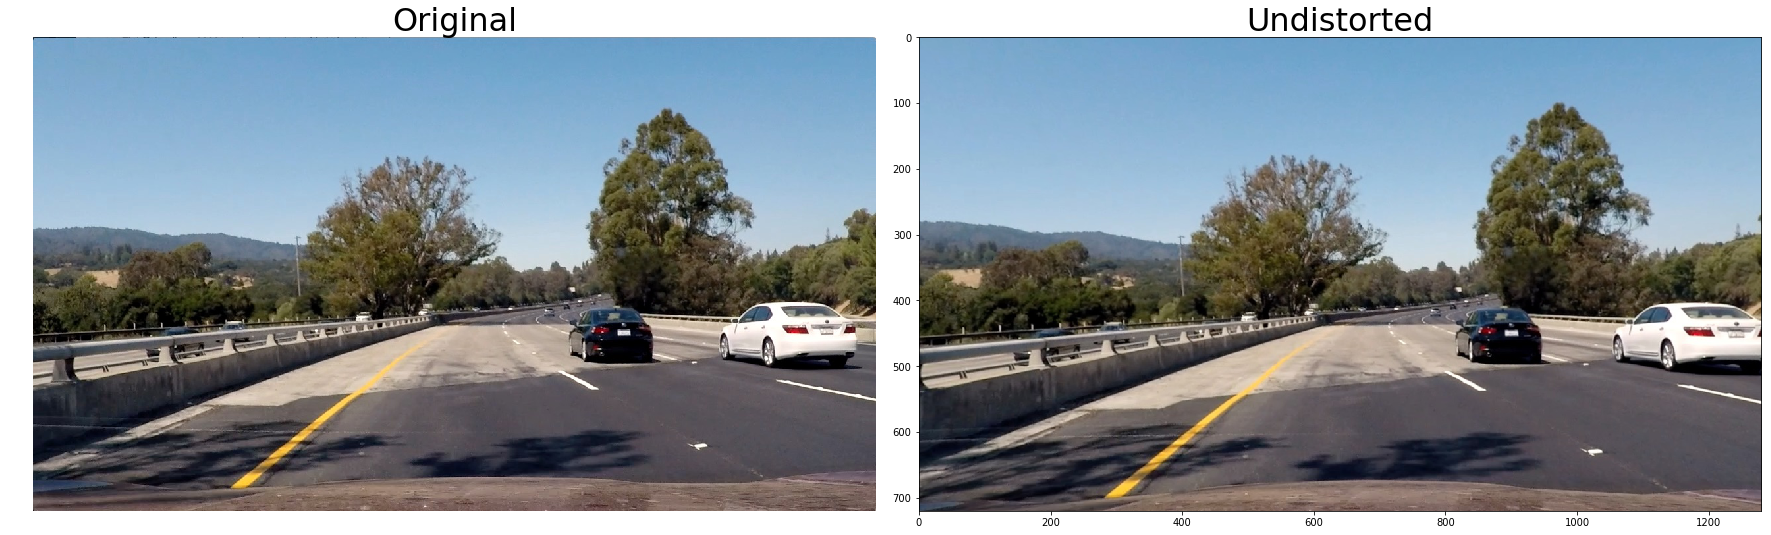

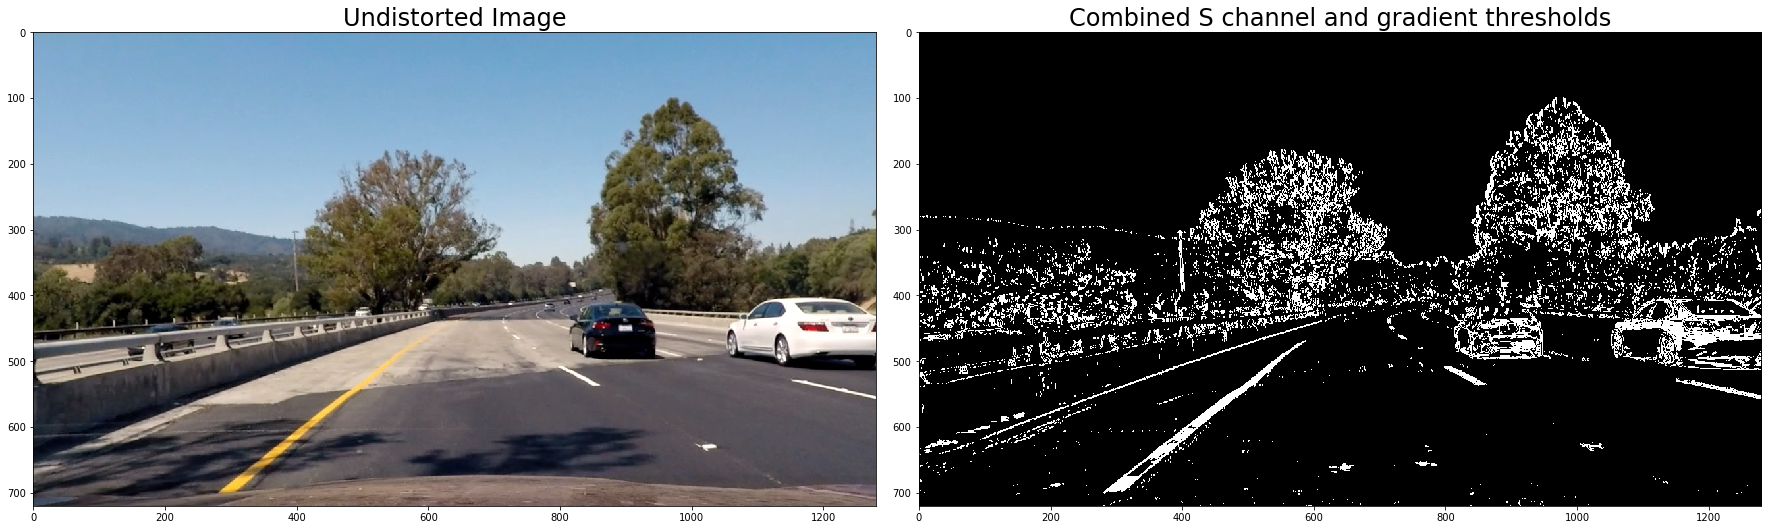

In [30]:
import numpy as np
import imageio
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# load Calibration data
dist_pickle = pickle.load( open( "./wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def pipeline_undistort(img, mtx, dist):
    """ Undistorts the input image. """
    return cv2.undistort(img, mtx, dist, None, mtx)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """

    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image, mask

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def pipeline(img, thresh=(0, 255), s_thresh=(0, 255)):
    rawImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(rawImg, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

def extract_rgb(img):
    R = np.zeros(img.shape, dtype='uint8')
    G = np.zeros(img.shape, dtype='uint8')
    B = np.zeros(img.shape, dtype='uint8')
    
    R[:,:,0] = img[:,:,0]
    G[:,:,1] = img[:,:,1]
    B[:,:,2] = img[:,:,2]
    
    return R,G,B

def extract_hls(img):
    H = np.zeros(img.shape, dtype='uint8')
    L = np.zeros(img.shape, dtype='uint8')
    S = np.zeros(img.shape, dtype='uint8')
    
    H[:,:,0] = img[:,:,0]
    L[:,:,1] = img[:,:,1]
    S[:,:,2] = img[:,:,2]
    
    return R,G,B

def threshold(img, thresh_min=0, thresh_max=255):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh_min) & (img <= thresh_max)] = 1
    return binary_output

def magThresh(img, sobel_kernel=3, thresh_min=0, thresh_max=255):
    """
    Calculate the Sobel magnitude gradient and return a binary thresholded image 
    on [`thresh_min`, `thresh_max`]. Using `sobel_kernel` as Sobel kernel size.
    """
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    return threshIt(gradmag, thresh_min, thresh_max)

def dirThresh(img, sobel_kernel=3, thresh_min=0, thresh_max=np.pi/2):
    """
    Calculate the Sobel direction gradient and return a binary thresholded image 
    on [`thresh_min`, `thresh_max`]. Using `sobel_kernel` as Sobel kernel size.
    """
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    return threshIt(absgraddir, thresh_min, thresh_max)

# test undistort
rawImg = cv2.imread('./test_images/test4.jpg')
rawImg = cv2.cvtColor(rawImg, cv2.COLOR_BGR2RGB)
hls = cv2.cvtColor(rawImg, cv2.COLOR_RGB2HLS)
gray = cv2.cvtColor(rawImg, cv2.COLOR_RGB2GRAY)

R = rawImg[:,:,0]
G = rawImg[:,:,1]
B = rawImg[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(R, cmap='gray')
ax1.axis('off')
ax1.set_title('R', fontsize=32)
ax2.imshow(G, cmap='gray')
ax2.axis('off')
ax2.set_title('G', fontsize=32)
ax3.imshow(B, cmap='gray')
ax3.axis('off')
ax3.set_title('B', fontsize=32)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H, cmap='gray')
ax1.axis('off')
ax1.set_title('H', fontsize=32)
ax2.imshow(L, cmap='gray')
ax2.axis('off')
ax2.set_title('L', fontsize=32)
ax3.imshow(S, cmap='gray')
ax3.axis('off')
ax3.set_title('S', fontsize=32)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

undist = pipeline_undistort(rawImg, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rawImg)
ax1.axis('off')
ax1.set_title('Original', fontsize=32)
ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=32)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

hls_binary = pipeline(undist, thresh=(20, 100), s_thresh=(170,255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=24)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Combined S channel and gradient thresholds', fontsize=24)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


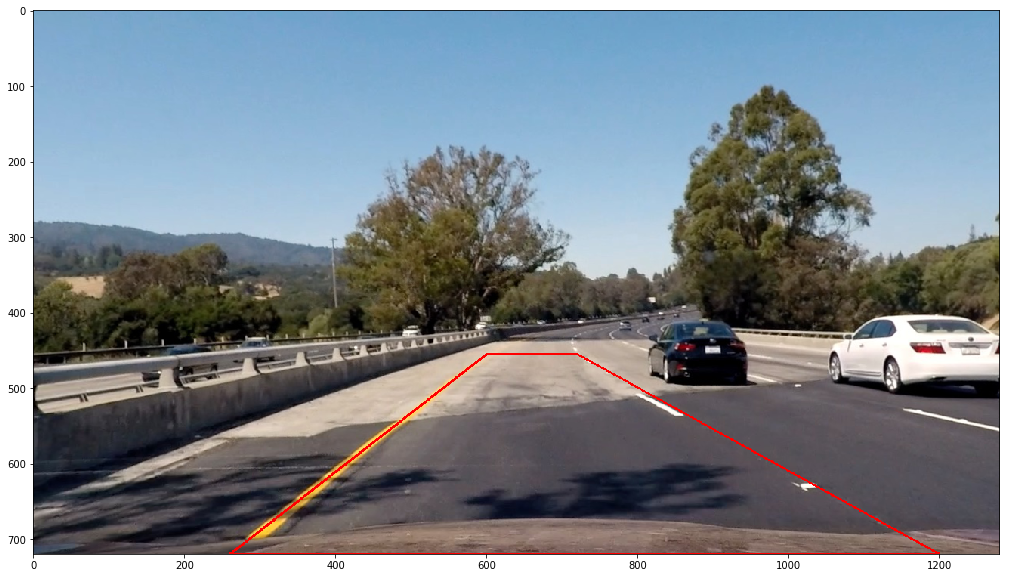

In [46]:
def perspective_transform(img, mtx, dist, isColor=True):

    xoffset = 50 # offset for dst points
    yoffset = 0
    img_size = (img.shape[1], img.shape[0])

   
    src = np.float32([(200, 700),(600, 450), (700,450),(1080, 700)])
  
   
    dst=np.float32([[350, 700], [350, 0],      [950, 0],[950, 700]]) 
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv


def region_of_interest(img):
    """Extracts region of interest from an image.
    
    Args:
      img: Image from which to extract region of interest.
      roi_vertices: Numpy array of x,y points specifying region of interest.
    Returns:
      New image containing only the pixels within the region of interest.
    """
    height = img.shape[0]
    width = img.shape[1]
    roi_vertices = np.array([[(150,height),((int(width/2)-20), int(height*3/5)), 
        (int((width/2)+50), int(height*3/5)), (width-50,height)]], dtype=np.int32)
    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, roi_vertices, 255)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

def image_wrap(img, src, dst, img_size):
    """
    Perpesctive transfor of an image based on source and destination image points.
    
    :param img:
        Image to transform
        
    :param: src:
        Source coordinates
        
    :param dst:
        Destination coordinates
        
    :param img_size:
        Image shape 
        
    :returns:
        Tuple of the warped image, the transform matrix and inverse transform matrix
    """
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

xSize, ySize, _ = undist.shape
copy = undist.copy()

bottomY = 720
topY = 455


left1 = (260, bottomY)
left1_x, left1_y = left1
left2 = (600, topY)
left2_x, left2_y = left2

right1 = (720, topY)
right1_x, right1_y = right1

right2 = (1200, bottomY)
right2_x, right2_y = right2

color = [255, 0, 0]
w = 2
cv2.line(copy, left1, left2, color, w)
cv2.line(copy, left2, right1, color, w)
cv2.line(copy, right1, right2, color, w)
cv2.line(copy, right2, left1, color, w)

plt.subplots(figsize=(20, 10))
plt.imshow(copy)
imageio.imwrite('./output_images/mask_area.jpg',copy)
plt.show()
